In [57]:

import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

In [58]:
#Read the data into a pandas data frame 
df = pd.read_parquet("de_train.parquet")
print(df.columns)

Index(['cell_type', 'sm_name', 'sm_lincs_id', 'SMILES', 'control', 'A1BG',
       'A1BG-AS1', 'A2M', 'A2M-AS1', 'A2MP1',
       ...
       'ZUP1', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', length=18216)


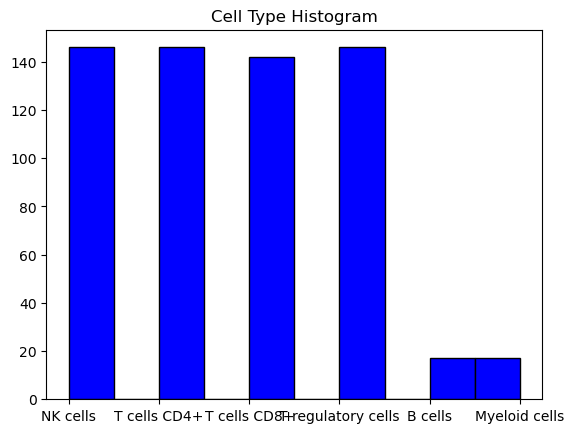

In [59]:
# Create a histogram for the cell_type column
plt.hist(df['cell_type'], bins=10, color='blue', edgecolor='black')

# Add labels and a title
#plt.xlabel('X-axis label')
#plt.ylabel('Y-axis label')
plt.title('Cell Type Histogram')

# Display the histogram
plt.show()

In [60]:
print(f"Here a few entries from the cell_type column: \n{df['cell_type'].head(10)}.\n")
print(f"Here a few entries from the sm_name column: \n{df['sm_name'].head(10)}.\n")
print(f"Here a few entries from the sm_lincs_id column: \n{df['sm_lincs_id'].head(10)}.\n")
print(f"Here a few entries from the SMILES column: \n{df['SMILES'].head(10)}.\n")
print(f"Here a few entries from the SMILES column: \n{df['SMILES'].head(10)}.\n")

Here a few entries from the cell_type column: 
0              NK cells
1          T cells CD4+
2          T cells CD8+
3    T regulatory cells
4              NK cells
5          T cells CD4+
6          T cells CD8+
7    T regulatory cells
8               B cells
9         Myeloid cells
Name: cell_type, dtype: object.

Here a few entries from the sm_name column: 
0          Clotrimazole
1          Clotrimazole
2          Clotrimazole
3          Clotrimazole
4    Mometasone Furoate
5    Mometasone Furoate
6    Mometasone Furoate
7    Mometasone Furoate
8            Idelalisib
9            Idelalisib
Name: sm_name, dtype: object.

Here a few entries from the sm_lincs_id column: 
0    LSM-5341
1    LSM-5341
2    LSM-5341
3    LSM-5341
4    LSM-3349
5    LSM-3349
6    LSM-3349
7    LSM-3349
8    LSM-1205
9    LSM-1205
Name: sm_lincs_id, dtype: object.

Here a few entries from the SMILES column: 
0               Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1
1               Clc1ccccc1C(c1ccccc1)(c1c

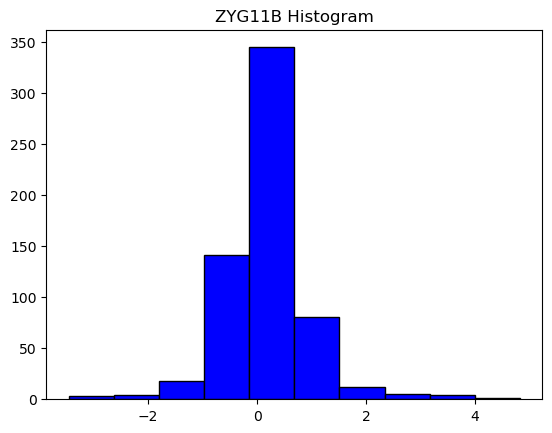

In [61]:
# Create a histogram for the cell_type column
plt.hist(df['ZYG11B'], bins=10, color='blue', edgecolor='black')

# Add labels and a title
plt.title('ZYG11B Histogram')

# Display the histogram
plt.show()

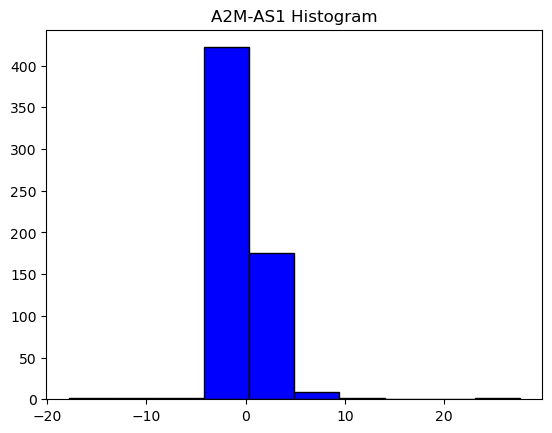

In [62]:
# Create a histogram for the cell_type column
plt.hist(df['A2M-AS1'], bins=10, color='blue', edgecolor='black')

# Add labels and a title
plt.title('A2M-AS1 Histogram')

# Display the histogram
plt.show()

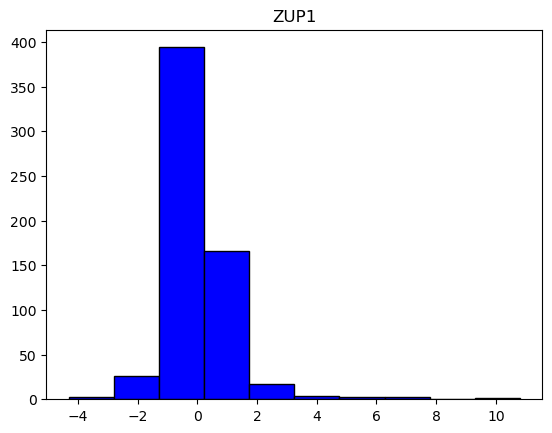

In [63]:
# Create a histogram for the cell_type column
plt.hist(df['ZUP1'], bins=10, color='blue', edgecolor='black')

# Add labels and a title
plt.title('ZUP1')

# Display the histogram
plt.show()

In [97]:
#normalizes data between -1 and 1
#returns normalized data and the factors used to normalzie 
def normalize(df):
    df_normalized = (df - df.min()) / (df.max() - df.min())
    return df_normalized


def unnormalize_dataframe(normalized_df, original_df):
    min_values = original_df.min()
    max_values = original_df.max()
    unnormalized_df = normalized_df * (max_values - min_values) + min_values
    return unnormalized_df

In [99]:
print(df.shape)
#One hot incode the inputs 
# Initialize the OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Fit and transform the data
cells = df["cell_type"].values.reshape(-1, 1)
hot_cells = encoder.fit_transform(cells)

compounds = df['sm_name'].values.reshape(-1, 1)
hot_compounds = encoder.fit_transform(compounds)

#put inputs and outputs together 
inputs = np.hstack((hot_cells, hot_compounds))
inputs_df = pd.DataFrame(data = inputs)
print(inputs_df.shape)
encoded_df = pd.concat([inputs_df, df.loc[:, 'A1BG':'ZZEF1']], axis=1)
print(encoded_df.iloc[1,200:210])

normalized_df = normalize(encoded_df)
print(normalized_df.iloc[1,200:210])
#encoded_df




(614, 18216)
(614, 152)
ABCD3    0.364560
ABCD4   -0.127843
ABCE1   -0.443234
ABCF1    1.906691
ABCF2   -0.897709
ABCF3   -0.181540
ABCG1   -1.634503
ABCG2   -0.030646
ABCG8   -0.074454
ABHD1   -0.337270
Name: 1, dtype: float64
ABCD3    0.274681
ABCD4    0.377059
ABCE1    0.282358
ABCF1    0.494459
ABCF2    0.155899
ABCF3    0.247260
ABCG1    0.319193
ABCG2    0.181860
ABCG8    0.195990
ABHD1    0.113671
Name: 1, dtype: float64


In [102]:
#Break into training and validation and split inputs from outputs
val, train = train_test_split(normalized_df, train_size=.2, random_state=3)
trainIn_df = train.loc[:, 0:151]
trainOut_df = train.loc[:, 'A1BG':'ZZEF1']
valIn_df = val.loc[:,0:151]
valOut_df = val.loc[:, 'A1BG':'ZZEF1']

print(type(trainIn_df))
trainIn_t = torch.tensor(trainIn_df.values)
trainOut_t = torch.tensor(trainOut_df.values)
valIn_t = torch.tensor(valIn_df.values)
valOut_t = torch.tensor(valOut_df.values)




<class 'pandas.core.frame.DataFrame'>


In [103]:
#Build each layer of nueral network
#Provide forward method to train network
class Layer1(nn.Module):
    def __init__(self, input_size, hidden1_size, num_classes):
        #Initialzing layers
        super(Layer1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, num_classes)
        self.act_output = nn.Sigmoid()
    #training function
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.act_output(out)
        return out
    
#Instantiate class with input, hidden layer, and output size 
model1 = Layer1(152,1024,18211)
#Change to double data type
model1.double()

Layer1(
  (fc1): Linear(in_features=152, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=18211, bias=True)
  (act_output): Sigmoid()
)

In [104]:
#Build each layer of nueral network
#Provide forward method to train network
class Layer2(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
        #Initialzing layers
        super(Layer2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden1_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden1_size, hidden2_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden2_size, num_classes)
        self.act_output = nn.Sigmoid()
    #training function
    def forward(self,x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.act_output(out)
        return out
    
#Instantiate class with input, hidden layer, and output size 
model2 = Layer2(152,1024,16384,18211)
#Change to double data type
model2.double()



Layer2(
  (fc1): Linear(in_features=152, out_features=1024, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=1024, out_features=16384, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16384, out_features=18211, bias=True)
  (act_output): Sigmoid()
)

In [105]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model1.parameters(), lr = 0.001)

In [106]:
# compute accuracy (no_grad is optional)
def deviation():
    with torch.no_grad():
        y_pred = model1(valIn_t)

    accuracy = (abs(y_pred-valOut_t)).float().mean()
    return (f"Deviation: {100*accuracy}%")



In [107]:
#training loop 
def train(epoch_number, batch_size):
    for epoch in range(epoch_number):
        for i in range(0, len(trainIn_t), batch_size):
            Xbatch = trainIn_t[i:i+batch_size]
            y_pred = model1(Xbatch)
            ybatch = trainOut_t[i:i+batch_size]
            loss = loss_fn(y_pred, ybatch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Finished epoch {epoch}, {deviation()}")


In [108]:
torch.cuda.is_available()

False

In [109]:
train(10,30)


Finished epoch 0, Deviation: 10.048151969909668%
Finished epoch 1, Deviation: 4.502105236053467%
Finished epoch 2, Deviation: 3.737588882446289%
Finished epoch 3, Deviation: 3.4216184616088867%
Finished epoch 4, Deviation: 3.3626582622528076%
Finished epoch 5, Deviation: 3.3650100231170654%
Finished epoch 6, Deviation: 3.3734230995178223%
Finished epoch 7, Deviation: 3.381882667541504%
Finished epoch 8, Deviation: 3.3884875774383545%
Finished epoch 9, Deviation: 3.394443988800049%


In [29]:
# find k value for given input adjusting for normalization

def kequals(inputs):
    answer = model(torch.DoubleTensor(inputs)/normalization_factor[:,0:7])
    return (answer*normalization_factor[:,7:9]).tolist()[0]

In [ ]:
load = 100000000
distance = .06
a1 = 0.02
a2 = 0.02
theta1 = .314
theta2 = .314
thickness = 0.01

x = []
k1 = []
k2 =[]
for i in range(100):
    varies = .01 + i*.01/100
    x.append(varies)
    answer = kequals([load, distance, a1,a2,theta1,theta2,varies])
    k1.append(answer[0])
    k2.append(answer[1])





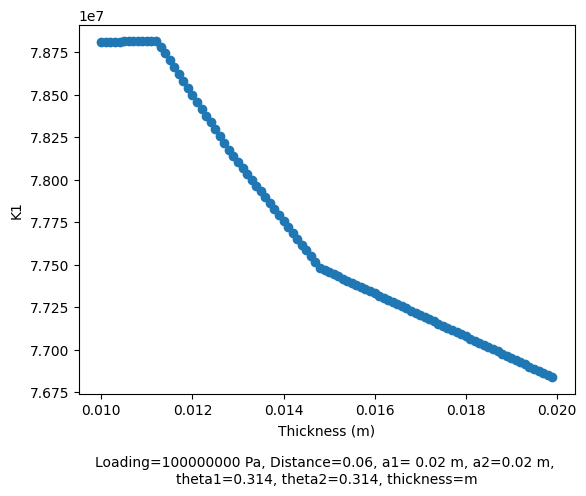

In [ ]:
#Output scatter plot for K1
plt.scatter(x,k1)
plt.xlabel(f"Thickness (m)\n\nLoading={load} Pa, Distance={distance}, a1= {a1} m, a2={a2} m, \ntheta1={theta1}, theta2={theta2}, thickness=m")
plt.ylabel("K1")
plt.show()

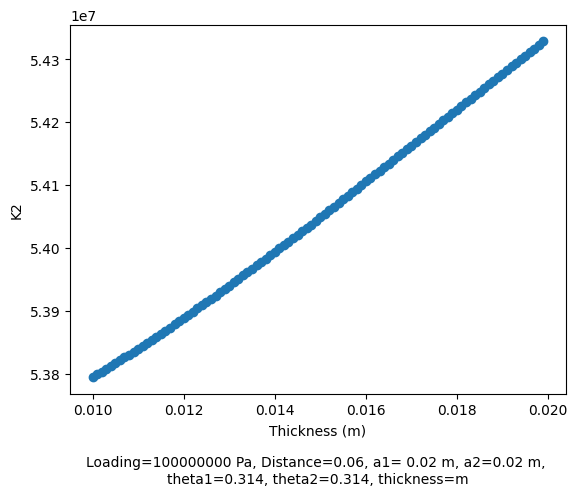

In [ ]:
#Output scatter plot for K2
plt.scatter(x,k2)
plt.xlabel(f"Thickness (m)\n\nLoading={load} Pa, Distance={distance}, a1= {a1} m, a2={a2} m, \ntheta1={theta1}, theta2={theta2}, thickness=m")
plt.ylabel("K2")
plt.show()

In [3]:
def evaluation_metrics():
    with torch.no_grad():
        y_pred = model1(valIn_t).numpy()
        y_true = valOut_t.numpy()

    # RMSE Calculation
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"Root Mean Square Error: {rmse}")

    # R2 Score Calculation
    r2 = r2_score(y_true, y_pred)
    print(f"R-squared: {r2}")

evaluation_metrics()

NameError: name 'torch' is not defined